In [1]:
import numpy as np
import math
from math import e
import pandas as pd
import qutip as qt
import random
from scipy.linalg import expm
import cmath

In [2]:
# function for checking whether or not matrix is hermitian
def check_hermitian(A):
    Adag = A.getH()
    if not (np.array_equal(np.matmul(Adag,A),np.matmul(A,Adag))):
        return False
    return True

In [3]:
def generate_hermitian(a,b,c,d):
    return np.matrix([[a,c+d*1j],[c-d*1j,b]])

In [4]:
def generate_random_hermitian(n):
    A = np.matrix(np.zeros((n,n),np.cdouble))
    constants = np.zeros(n*n)
    for i in range(0,n*n):
        constants[i] = random.random()
    constant_iter = 0
    for i in range(0,n-1):
        A[i,i] = constants[constant_iter]
        constant_iter += 1
        for j in range(i+1,n):
            A[i,j] = constants[constant_iter] + 1j*constants[constant_iter+1]
            A[j,i] = constants[constant_iter] - 1j*constants[constant_iter+1]
            constant_iter += 2
    A[n-1,n-1] = constants[constant_iter]
    return A

In [7]:
dim = 5
A=generate_random_hermitian(dim)

In [8]:
# should always be true
check_hermitian(A)

True

In [9]:
A

matrix([[0.88422619+0.j        , 0.28266108+0.79844834j,
         0.55290419+0.76571922j, 0.04616089+0.11715428j,
         0.62677529+0.37347227j],
        [0.28266108-0.79844834j, 0.98933435+0.j        ,
         0.01386045+0.94585761j, 0.45026862+0.34007871j,
         0.26553817+0.30066494j],
        [0.55290419-0.76571922j, 0.01386045-0.94585761j,
         0.71116386+0.j        , 0.77699701+0.16115797j,
         0.77730391+0.54034355j],
        [0.04616089-0.11715428j, 0.45026862-0.34007871j,
         0.77699701-0.16115797j, 0.80752495+0.j        ,
         0.09250756+0.60355829j],
        [0.62677529-0.37347227j, 0.26553817-0.30066494j,
         0.77730391-0.54034355j, 0.09250756-0.60355829j,
         0.83410434+0.j        ]])

In [5]:
def get_magnitude(v):
    sum_of_squares = 0
    for i in v:
        sum_of_squares += i**2
    return cmath.sqrt(sum_of_squares)

In [6]:
# v: inital state
# A: hamiltonian
# t: time-step of new state
def evolve(v,A,t):
    A = -A*1j*t
    A = expm(A)
    return np.matmul(A,v)

In [12]:
vec_2d = np.random.rand(2)
vec_2d = vec_2d/get_magnitude(vec_2d)
A_2d = generate_random_hermitian(2)

In [13]:
timestep = 7
evolve(vec_2d,A_2d,timestep)

array([-0.70852234-0.68397919j, -0.16326068+0.05928323j])

In [14]:
# hardcode verification of evolve function, should yield same result as above
e1 = np.linalg.eigvals(A_2d)[0]
e2 = np.linalg.eigvals(A_2d)[1]
I = np.matrix([[1+0*1j,0+0*1j],[0+0*1j,1+0*1j]])
term1 = I*(e2*e**(-e1*1j*timestep)-e1*e**(-e2*1j*timestep))/(e2-e1)
term2 = A_2d*(e**(-e2*1j*timestep)-e**(-e1*1j*timestep))/(e2-e1)

mat_exp = term1+term2 
np.matmul(mat_exp,vec_2d)

matrix([[-0.70852234-0.68397919j, -0.16326068+0.05928323j]])

In [7]:
# v: inital state as a complex vector with two dimensions
# A: hamiltonian defining the evolution of the state
# n: number of evolutions, the number of state vectors in the returned evolution_matrix
def generate_evolution_matrix(v,A,n,t_step=1):
    evolution_matrix = np.array([v,evolve(v,A,t_step)])
    for i in range(2,n):
        evolution_matrix = np.vstack( (evolution_matrix,np.array([evolve(v,A,i*t_step)])) )
    return evolution_matrix

Hamiltonian:
 [[0.0292192 +0.j         0.36274032+0.00129125j]
 [0.36274032-0.00129125j 0.78156985+0.j        ]]
Initial State:
 [0.64417065+0.j 0.7648818 +0.j]


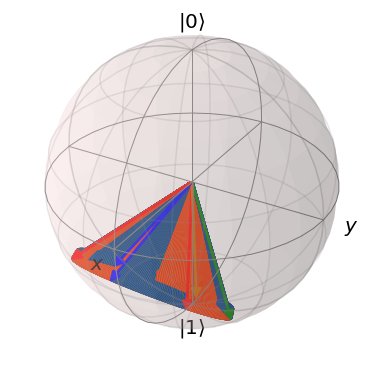

In [16]:
# choose random coefficients for hermitian hamiltonian
a=random.random()
b=random.random()
c=random.random()
d=random.random()
H = generate_hermitian(a,b,c,d)

# generate random 2 dimensional vector
initial_state = np.random.rand(2)

# change vector to have norm of 1
initial_state = initial_state/get_magnitude(initial_state)

# choose number of evolutions
num_rows = 1000
evolution_matrix = generate_evolution_matrix(initial_state,H,num_rows)

#extract real and imaginary parts out of evolution matrix
split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])

#visualize on bloch sphere
b = qt.Bloch()
state_matrix = np.empty(num_rows, dtype=qt.Qobj)
for i in range(0,num_rows):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])
b.add_states(state_matrix)
b.render()

# print hamiltonian and initial vector
print("Hamiltonian:\n",H)
print("Initial State:\n",initial_state)

In [8]:
# unspecified dimension defaults to 2x2 hamiltonian
def generate_data_2d(filename,ham_filename,num_evolutions,H=None,t_step=1):
    
    # choose random coefficients for hermitian hamiltonian if one is not provided
    if type(H) != np.ndarray:
        a=random.random()
        b=random.random()
        c=random.random()
        d=random.random()
        H = generate_hermitian(a,b,c,d)

    # generate random 2 dimensional vector
    vec = np.random.rand(2)

    # change vector to have norm of 1
    vec = vec/get_magnitude(vec)

    # choose number of evolutions
    num_rows = num_evolutions
    evolution_matrix = generate_evolution_matrix(vec,H,num_rows,t_step=t_step)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
    for row in range(0,evolution_matrix.shape[0]):
        split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
        split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
        split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
        split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
    # export data as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)
    ham_df = pd.DataFrame(H)
    ham_df.to_csv(ham_filename)

In [18]:
# generalization for any dimensionality
def generate_data(filename,ham_filename,num_evolutions,dim,H=None,t_step=1):
    if type(H) != np.ndarray:
        H = generate_random_hermitian(dim)
    vec = np.zeros(dim,np.cdouble)
    vec[0] = 1+0*1j
    evolution_matrix = generate_evolution_matrix(vec,H,num_evolutions,t_step=t_step)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],dim*2))
    for row in range(0,evolution_matrix.shape[0]):
        for i in range(0,dim):
            split_evolution_matrix[row,2*i] = np.real(evolution_matrix[row,i])
            split_evolution_matrix[row,2*i+1] = np.imag(evolution_matrix[row,i])
    
    # export data as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)
    ham_df = pd.DataFrame(H)
    ham_df.to_csv(ham_filename)

In [19]:
for i in range(1,31):
    filename = "data/evolution_data/evolution_data" + str(i) + ".csv"
    ham_filename = "data/hamiltonians/hamiltonian" + str(i) + ".csv"
    generate_data_2d(filename,ham_filename,3000)

In [20]:
generate_data("evolution_data.csv","hamiltonian.csv",1000,50)